In [1]:
import torch

In [5]:
import src.conv_onet.models.decoder as decoder
from torchsummary import summary

nn = decoder.NICE(hidden_size=32, coarse=True).to("cuda:0")

print(summary(nn))

Layer (type:depth-idx)                             Param #
├─MLP_no_xyz: 1-1                                  --
|    └─ModuleList: 2-1                             --
|    |    └─DenseLayer: 3-1                        1,056
|    |    └─DenseLayer: 3-2                        1,056
|    |    └─DenseLayer: 3-3                        1,056
|    |    └─DenseLayer: 3-4                        2,080
|    |    └─DenseLayer: 3-5                        1,056
|    └─DenseLayer: 2-2                             33
├─MLP: 1-2                                         --
|    └─ModuleList: 2-3                             --
|    |    └─Linear: 3-6                            1,056
|    |    └─Linear: 3-7                            1,056
|    |    └─Linear: 3-8                            1,056
|    |    └─Linear: 3-9                            1,056
|    |    └─Linear: 3-10                           1,056
|    └─GaussianFourierFeatureTransform: 2-4        279
|    └─ModuleList: 2-5                        

In [4]:
import src.config as config

cfg = config.load_config("./configs/Replica/room0.yaml", "./configs/nice_slam.yaml")

In [8]:
import numpy as np

def load_pretrain(nice: decoder.NICE, cfg: dict):
    ckpt = torch.load(cfg['pretrained_decoders']['coarse'], map_location=cfg['mapping']['device'])
    coarse_dict = {}
    for key, val in ckpt['model'].items():
        if ('decoder' in key) and ('encoder' not in key):
            key = key[8:]
            coarse_dict[key] = val
    nice.coarse_decoder.load_state_dict(coarse_dict)

    ckpt = torch.load(cfg['pretrained_decoders']['middle_fine'], map_location=cfg['mapping']['device'])
    middle_dict = {}
    fine_dict = {}
    for key, val in ckpt['model'].items():
        if ('decoder' in key) and ('encoder' not in key):
            if 'coarse' in key:
                key = key[8+7:]
                middle_dict[key] = val
            elif 'fine' in key:
                key = key[8+5:]
                fine_dict[key] = val
    nice.middle_decoder.load_state_dict(middle_dict)
    nice.fine_decoder.load_state_dict(fine_dict)

    scale = cfg['scale']

    bound = torch.from_numpy(np.array(cfg['mapping']['bound'])*scale)
    bound_divisible = cfg['grid_len']['bound_divisible']
    bound[:, 1] = (((bound[:, 1]-bound[:, 0]) /
        bound_divisible).int()+1)*bound_divisible+bound[:, 0]

    nice.bound = bound
    nice.middle_decoder.bound = bound
    nice.fine_decoder.bound = bound
    nice.color_decoder.bound = bound
    nice.coarse_decoder.bound = bound * cfg['model']['coarse_bound_enlarge']

In [9]:
load_pretrain(nn, cfg)

In [10]:
import os

stages = ["coarse", "middle", "fine", "color"]

for stage in stages:
    for pt in os.listdir(f"./saved_inputs/{stage}")[:10]:
        data = torch.load(f"./saved_inputs/{stage}/{pt}")
        pi = data['pi'].to(cfg['mapping']['device'])
        c = data['c']
        print(nn(pi, c_grid=c, stage=stage).shape)

torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([32000, 4])
torch.Size([47952, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([47952, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])
torch.Size([48000, 4])
torch.Size([9600, 4])


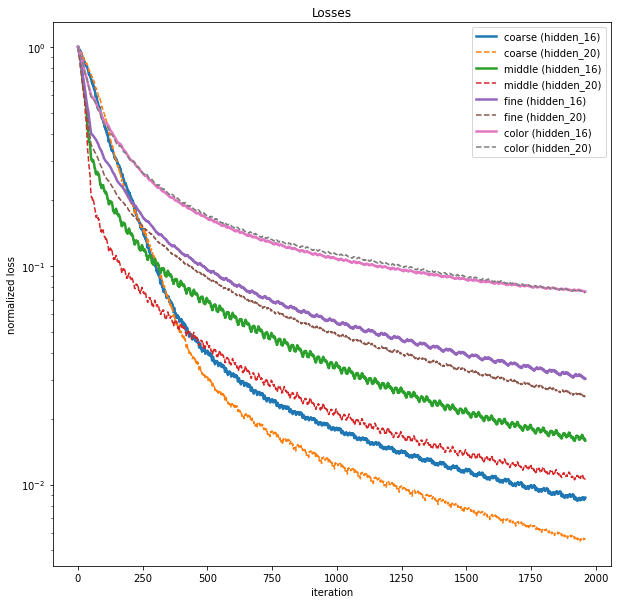

In [15]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open("./saved_slim/hidden_16/loss_record.pkl", "rb") as f:
    loss_record_16 = pickle.load(f)

with open("./saved_slim/hidden_20/loss_record.pkl", "rb") as f:
    loss_record_20 = pickle.load(f)

stages = ["coarse", "middle", "fine", "color"]

plt.figure(figsize=(10, 10))

running_avg_len = 40

for i, stage in enumerate(stages):
    # Plot the loss record for hidden_16
    smoothed_loss_16 = np.convolve(loss_record_16[stage], np.ones(running_avg_len)/running_avg_len, mode='valid')
    normalized_loss_16 = smoothed_loss_16 / np.max(smoothed_loss_16)
    plt.plot(normalized_loss_16, label=f"{stage} (hidden_16)", linestyle='-', linewidth=2.5)

    # Plot the loss record for hidden_20
    smoothed_loss_20 = np.convolve(loss_record_20[stage], np.ones(running_avg_len)/running_avg_len, mode='valid')
    normalized_loss_20 = smoothed_loss_20 / np.max(smoothed_loss_20)
    plt.plot(normalized_loss_20, label=f"{stage} (hidden_20)", linestyle='--')

plt.title('Losses')
plt.xlabel('iteration')
plt.ylabel('normalized loss')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()
